In [20]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import wandb
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim
from torchkan import KAN
from KACnet import KAC_Net
from KALnet import KAL_Net
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import torch

### 定义训练函数

In [21]:
def train_and_validate_model(model, epochs, learning_rate, train_loader, val_loader, model_name):
    '''
    这段代码是用Python编写的，主要用于训练一个神经网络模型。以下是代码的详细解释：

1. 首先，导入所需的库和模块。这里使用了PyTorch（nn和optim模块）和wandb（用于跟踪训练过程）。

2. 定义损失函数（均方误差损失）和优化器（随机梯度下降）。

3. 定义学习率调度器（StepLR），用于在每个训练周期后调整学习率。这里设置了步长为10，gamma为0.5，这意味着每10个周期，学习率将乘以0.5。

4. 定义训练和验证数据加载器（train_loader和val_loader）。

5. 定义训练循环，共进行epochs个周期。在每个周期中：

   a. 将模型设置为训练模式（model.train()）。

   b. 初始化总损失为0（total_loss = 0）。

   c. 遍历训练数据加载器（for x, y in train_loader:），对每个输入（x）和目标（y）进行以下操作：

      i. 清除梯度（optimizer.zero_grad()）。
/
      ii. 使用模型预测输出（predicted_y = model(x)）。

      iii. 计算损失（loss = loss_fn(predicted_y, y.unsqueeze(1))）。

      iv. 反向传播损失（loss.backward()）。

      v. 更新模型参数（optimizer.step()）。

      vi. 将损失累加到总损失中（total_loss += loss.item()）。

   d. 更新学习率（scheduler.step()）。

   e. 计算平均训练损失（avg_loss = total_loss / len(train_loader)），并使用wandb记录训练损失（wandb.log({f"{model_name} Train Loss": avg_loss})）。

6. 将模型设置为评估模式（model.eval()）。

7. 初始化总验证损失为0（total_val_loss = 0）。

8. 遍历验证数据加载器（for x, y in val_loader:），对每个输入（x）和目标（y）进行以下操作：

   a. 使用模型预测输出（predicted_y = model(x)）。

   b. 计算验证损失（val_loss = loss_fn(predicted_y, y.unsqueeze(1))）。

   c. 将验证损失累加到总验证损失中（total_val_loss += val_loss.item()）。

9. 计算平均验证损失（avg_val_loss = total_val_loss / len(val_loader)），并使用wandb记录验证损失（wandb.log({f"{model_name} Validation Loss": avg_val_loss})）。

10. 打印训练和验证损失（print(f"Epoch {epoch}, {model_name} Train Loss: {avg_loss}, Validation Loss: {avg_val_loss}")）。

总之，这段代码实现了一个简单的神经网络模型训练过程，包括训练和验证损失的计算、学习率的调度以及训练过程的记录。

'''
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    train_losses=[]
    val_losses=[]
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            predicted_y = model(x)
            loss = loss_fn(predicted_y, y.unsqueeze(1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        scheduler.step()
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                predicted_y = model(x)
                val_loss = loss_fn(predicted_y, y.unsqueeze(1))
                total_val_loss += val_loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch}, {model_name} Train Loss: {avg_loss}, Validation Loss: {avg_val_loss}")
    loss_df = pd.DataFrame({"Epoch": list(range(1, epochs + 1)),
                        f"{model_name} Train Loss": train_losses,
                        f"{model_name} Validation Loss": val_losses})
    loss_df.to_excel(f"{model_name} loss_result.xlsx", index=False)
    


### 定义测试函数

In [22]:
def evaluate_model(model, eval_loader, model_name):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for x, y in eval_loader:
            predicted_y = model(x)
            predictions.extend(predicted_y.squeeze().cpu().numpy())
            actuals.extend(y.cpu().numpy())
    return predictions, actuals

### 定义MLP模型

In [23]:
class MLP(nn.Module):
    def __init__(self, layers):
        super(MLP, self).__init__()
        mlp_layers = []
        for i in range(len(layers) - 1):
            mlp_layers.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers) - 2:
                mlp_layers.append(nn.ReLU())
        self.model = nn.Sequential(*mlp_layers)

    def forward(self, x):
        return self.model(x)

### 读取并清洗数据

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 读取xlsx文件
file_path = 'D:\OneDrive - Officials\OneDrive - Mraz Cindy\done\毕设资料\计算公式说明\数据库.xlsx'  # 替换为你的xlsx文件路径
df = pd.read_excel(file_path, engine='openpyxl')

# 打乱行顺序并按8:2的比例分成训练集和测试集
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
# 提取第2，3，4，5列的数据
input = train_df.iloc[:, 1:5]
output = train_df.iloc[:, 5:7]
test_input = test_df.iloc[:, 1:5]
test_label = test_df.iloc[:, 5:7]
# 将DataFrame转换为numpy数组并调整其维度为4
array1 = input.to_numpy()
array2 = output.to_numpy()
array3 = test_input.to_numpy()
array4 = test_label.to_numpy()
input=torch.tensor(array1, dtype=torch.float32)
ouput=torch.tensor(array2, dtype=torch.float32)
test_input=torch.tensor(array3, dtype=torch.float32)
test_label=torch.tensor(array4, dtype=torch.float32)
def normalize_columns(tensor):
    # 确保输入是2D张量
    assert tensor.dim() == 2, "Input tensor must be 2D"
    
    # 获取最小值和最大值
    col_min = tensor.min(dim=0, keepdim=True).values
    col_max = tensor.max(dim=0, keepdim=True).values
    
    # 防止除以零的情况
    denom = col_max - col_min
    denom[denom == 0] = 1  # 如果列中所有值相等，避免除以零
    
    # 进行归一化
    normalized_tensor = (tensor - col_min) / denom
    return normalized_tensor
# 对每一列进行归一化
input= normalize_columns(input)
ouput= normalize_columns(ouput)
test_input= normalize_columns(test_input)
test_label= normalize_columns(test_label)
dataset={'train_input':input,'test_input':test_input,'train_label':ouput,'test_label':test_label}

# 输出结果
print("训练集样本数:", len(train_df))
print("测试集样本数:", len(test_df))

训练集样本数: 307
测试集样本数: 77


### 跑模型

In [25]:

dimension=4
# Define model layers
layers = [dimension, 9, 5, 2]
x_data=torch.cat((input,test_input),0)
y_data=torch.cat((ouput,test_label),0)

# 定义一个TensorDataset对象，将x_data和y_data传入
dataset = TensorDataset(x_data, y_data)
# 计算训练集和验证集的数量
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
# 将数据集划分为训练集和验证集
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
# 创建训练集的DataLoader对象，批量大小为32，打乱数据
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# 创建验证集的DataLoader对象，批量大小为32，不打乱数据
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Initialize and train the KAN model
kan_model = KAN(layers)
train_and_validate_model(kan_model, epochs=50, learning_rate=0.001, train_loader=train_loader, val_loader=val_loader, model_name=f"KAN")
    # Initialize and train the MLP model
mlp_model = MLP(layers)
train_and_validate_model(mlp_model, epochs=50, learning_rate=0.001, train_loader=train_loader, val_loader=val_loader, model_name=f"MLP")
    # Initialize and train the KAC_net model
kac_model = KAC_Net(layers)
train_and_validate_model(kac_model, epochs=50, learning_rate=0.001, train_loader=train_loader, val_loader=val_loader, model_name=f"KAC_Net")
    # Initialize and train the KAL_net model
kal_model = KAL_Net(layers)
train_and_validate_model(kal_model, epochs=50, learning_rate=0.001, train_loader=train_loader, val_loader=val_loader, model_name=f"KAL_Net")
    # Evaluate both models
# 调用evaluate_model函数，传入kan_model、val_loader、"KAN"
kan_predictions, kan_actuals = evaluate_model(kan_model, val_loader, f"KAN")
# 调用evaluate_model函数，传入mlp_model、val_loader、"MLP"
mlp_predictions, mlp_actuals = evaluate_model(mlp_model, val_loader, f"MLP")
# 调用evaluate_model函数，传入kac_model、val_loader、"KAC_Net"
kac_predictions, kac_actuals = evaluate_model(kac_model, val_loader, f"KAC_Net")
# 调用evaluate_model函数，传入kal_model、val_loader、"KAL_Net"
kal_predictions, kal_actuals = evaluate_model(kal_model, val_loader, f"KAL_Net")
# 定义kan_data，用于存储kan_predictions和kan_actuals
    # Log results to wandb
# 调用wandb.log函数，传入kan_data
import csv

def save_to_csv(kan_predictions, kan_actuals, mlp_predictions, mlp_actuals, kac_predictions, kac_actuals, kal_predictions, kal_actuals):
    # 打开或创建 CSV 文件
    with open('output.csv', 'w', newline='') as file:
        writer = csv.writer(file)

        # 写入标题行
        writer.writerow(["KAN_Predictions", "KAN_Actuals", "MLP_Predictions", "MLP_Actuals", "KAC_Net_Predictions", "KAC_Net_Actuals", "KAL_Net_Predictions", "KAL_Net_Actuals"])

        # 写入数据行
        for i in range(len(kan_predictions)):
            writer.writerow([kan_predictions[i], kan_actuals[i], mlp_predictions[i], mlp_actuals[i], kac_predictions[i], kac_actuals[i], kal_predictions[i], kal_actuals[i]])

# 假设您已经有了这些变量的值，调用函数进行保存
save_to_csv(kan_predictions, kan_actuals, mlp_predictions, mlp_actuals, kac_predictions, kac_actuals, kal_predictions, kal_actuals)
    # Save model states
# 保存kan_model的状态字典到文件"kan inverse.pth"
#torch.save(kan_model.state_dict(), f"kan inverse.pth")
# 保存mlp_model的状态字典到文件"mlp inverse.pth"
#torch.save(mlp_model.state_dict(), f"mlp inverse.pth")
# 保存kac_model的状态字典到文件"kac_net inverse.pth"
#torch.save(kac_model.state_dict(), f"kac_net inverse.pth")
# 保存kal_model的状态字典到文件"kal_net inverse.pth"
#torch.save(kal_model.state_dict(), f"kal_net inverse.pth")


Epoch 0, KAN Train Loss: 0.5403186447090573, Validation Loss: 0.534214086830616
Epoch 1, KAN Train Loss: 0.5234737197558085, Validation Loss: 0.5129493325948715
Epoch 2, KAN Train Loss: 0.4985547728008694, Validation Loss: 0.4943764954805374


f:\mycode\pykan\kannet\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32, 1, 2])) that is different to the input size (torch.Size([32, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
f:\mycode\pykan\kannet\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([12, 1, 2])) that is different to the input size (torch.Size([12, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
f:\mycode\pykan\kannet\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([20, 1, 2])) that is different to the input size (torch.Size([20, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  ret

Epoch 3, KAN Train Loss: 0.47883936762809753, Validation Loss: 0.46236706525087357
Epoch 4, KAN Train Loss: 0.4382740987671746, Validation Loss: 0.42134494334459305
Epoch 5, KAN Train Loss: 0.3987474938233693, Validation Loss: 0.39515669643878937
Epoch 6, KAN Train Loss: 0.39205041858885026, Validation Loss: 0.38927971571683884
Epoch 7, KAN Train Loss: 0.36998121274842155, Validation Loss: 0.3649148941040039
Epoch 8, KAN Train Loss: 0.357757310072581, Validation Loss: 0.3406201973557472
Epoch 9, KAN Train Loss: 0.31823672519789803, Validation Loss: 0.301581546664238
Epoch 10, KAN Train Loss: 0.29306912422180176, Validation Loss: 0.2903292775154114
Epoch 11, KAN Train Loss: 0.2990639739566379, Validation Loss: 0.29176606982946396
Epoch 12, KAN Train Loss: 0.290588335858451, Validation Loss: 0.2845075875520706
Epoch 13, KAN Train Loss: 0.28986629843711853, Validation Loss: 0.2770822048187256
Epoch 14, KAN Train Loss: 0.2818249397807651, Validation Loss: 0.2713356390595436
Epoch 15, KAN T

### 用shap分析模型

In [26]:
import shap

def explain_model_with_shap(model, data_loader):
    # Convert DataLoader to a single tensor for SHAP
    all_data = torch.cat([data for data, _ in data_loader], dim=0)
    
    # Create a SHAP explainer
    explainer = shap.DeepExplainer(model, all_data)
    
    # Get SHAP values
    shap_values = explainer.shap_values(all_data)
    
    return shap_values, all_data
# After training the models
models = {
    "KAN": kan_model,
    "MLP": mlp_model,
    "KAC_Net": kac_model,
    "KAL_Net": kal_model
}

for model_name, model in models.items():
    print(f"Explaining model: {model_name}")
    shap_values, all_data = explain_model_with_shap(model, val_loader)
    
    # Plot the SHAP values
    shap.summary_plot(shap_values, all_data, feature_names=['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4'])



Explaining model: KAN


f:\mycode\pykan\kannet\Lib\site-packages\shap\explainers\_deep\deep_pytorch.py:243: UserWarning: unrecognized nn.Module: PReLU
  warnings.warn(f'unrecognized nn.Module: {module_type}')
f:\mycode\pykan\kannet\Lib\site-packages\shap\explainers\_deep\deep_pytorch.py:243: UserWarning: unrecognized nn.Module: LayerNorm
  warnings.warn(f'unrecognized nn.Module: {module_type}')
f:\mycode\pykan\kannet\Lib\site-packages\shap\explainers\_deep\deep_pytorch.py:243: UserWarning: unrecognized nn.Module: GELU
  warnings.warn(f'unrecognized nn.Module: {module_type}')


AssertionError: The SHAP explanations do not sum up to the model's output! This is either because of a rounding error or because an operator in your computation graph was not fully supported. If the sum difference of %f is significant compared to the scale of your model outputs, please post as a github issue, with a reproducible example so we can debug it. Used framework: pytorch - Max. diff: 0.8398767858743668 - Tolerance: 0.01

Explaining model: KAN


TypeError: only integer scalar arrays can be converted to a scalar index

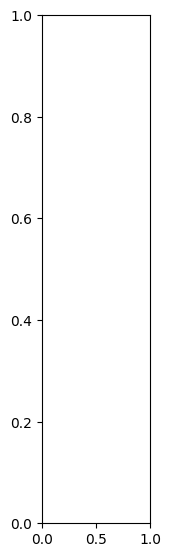

In [27]:
import shap
import torch

def explain_model_with_shap_gradient(model, data_loader):
    model.eval()
    all_data = torch.cat([data for data, _ in data_loader], dim=0)
    
    explainer = shap.GradientExplainer(model, all_data)
    shap_values = explainer.shap_values(all_data)
    
    return shap_values, all_data
# After training the models
models = {
    "KAN": kan_model,
    "MLP": mlp_model,
    "KAC_Net": kac_model,
    "KAL_Net": kal_model
}

for model_name, model in models.items():
    print(f"Explaining model: {model_name}")
    shap_values, all_data = explain_model_with_shap_gradient(model, val_loader)
    
    # Plot the SHAP values
    shap.summary_plot(shap_values, all_data, feature_names=['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4'])


Using 116 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Explaining model: KAN


  0%|          | 0/116 [00:00<?, ?it/s]

TypeError: only integer scalar arrays can be converted to a scalar index

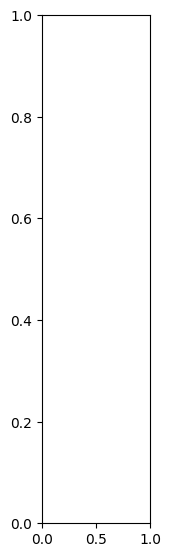

In [28]:
import shap
import torch

def explain_model_with_shap_kernel(model, data_loader):
    model.eval()
    all_data = torch.cat([data for data, _ in data_loader], dim=0)
    
    def model_predict(x):
        with torch.no_grad():
            return model(torch.tensor(x, dtype=torch.float)).numpy()
    
    explainer = shap.KernelExplainer(model_predict, all_data.numpy())
    shap_values = explainer.shap_values(all_data.numpy(), nsamples=100)  # Adjust nsamples as needed
    
    return shap_values, all_data
# After training the models
models = {
    "KAN": kan_model,
    "MLP": mlp_model,
    "KAC_Net": kac_model,
    "KAL_Net": kal_model
}

for model_name, model in models.items():
    print(f"Explaining model: {model_name}")
    shap_values, all_data = explain_model_with_shap_kernel(model, val_loader)
    
    # Plot the SHAP values
    shap.summary_plot(shap_values, all_data, feature_names=['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4'])
